In [32]:
import pennylane as qml
from pennylane import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
from functools import partial

In [33]:
tf.config.set_visible_devices([], 'GPU')
tf.keras.backend.set_floatx('float64')

In [34]:
n_train = 500
n_test  = 50
num_qubits = 4

In [35]:
dev = qml.device('lightning.qubit', wires=4)

#@partial(qml.batch_input, argnum = 1)
@qml.qnode(dev,interface="tf", diff_method="parameter-shift")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    qml.RY(weights[0], wires=[3])
    qml.Hadamard(wires=[1])
    qml.S(wires=[1])
    qml.RY(weights[1], wires=[0])
    #qml.RZ(weights[2], wires=[0])
    qml.RY(weights[2], wires=[2])

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [36]:
def QNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4) 
    
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Counter({0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50})


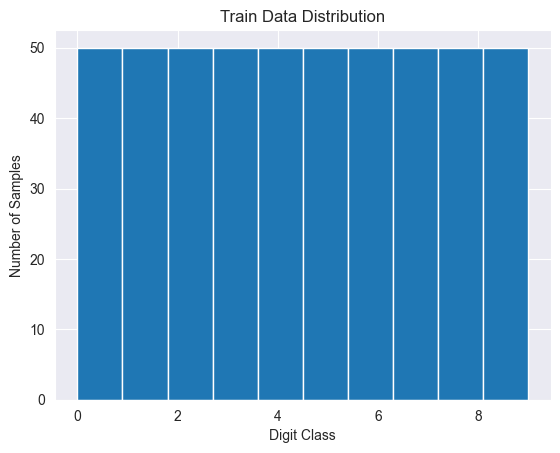

Counter({0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5})


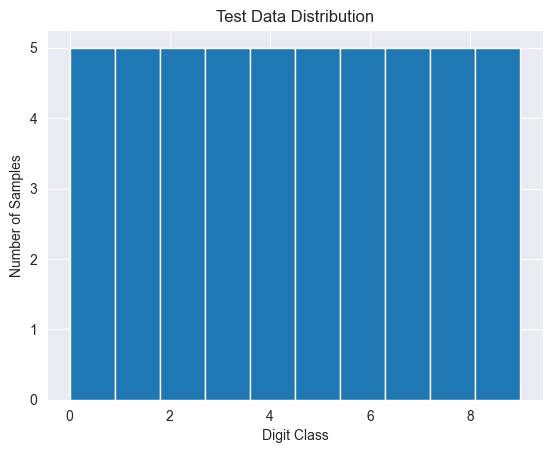

In [37]:
import pickle

def load_dataset(train_size, test_size):
    fashion_mnist = tf.keras.datasets.fashion_mnist
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    # --- Train Set ---
    train_idx_by_class = [np.where(train_labels == i)[0] for i in range(10)]  
    train_idx_selected = [
        np.random.choice(idxs, min(len(idxs), train_size // 10), replace=False)  # Adjusted for train_size
        for idxs in train_idx_by_class
    ]
    train_idx_selected = np.concatenate(train_idx_selected) 

    train_images = train_images[train_idx_selected]
    train_labels = train_labels[train_idx_selected]

    # --- Test Set --- (Apply the same logic)
    test_idx_by_class = [np.where(test_labels == i)[0] for i in range(10)] 
    test_idx_selected = [
        np.random.choice(idxs, min(len(idxs), test_size // 10), replace=False)  # Adjusted for test_size
        for idxs in test_idx_by_class
    ]
    test_idx_selected = np.concatenate(test_idx_selected) 

    test_images = test_images[test_idx_selected]
    test_labels = test_labels[test_idx_selected]

    # Normalize pixel values within 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Add extra dimension for convolution channels
    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)
    
    #new_height = 14  # 28 / 2
    #new_width = 14  # 28 / 2 
    #train_images = tf.image.resize(train_images, (new_height, new_width))
    #test_images = tf.image.resize(test_images, (new_height, new_width))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_dataset(n_train, n_test)

label_counts = collections.Counter(train_labels)
print(label_counts)

plt.hist(train_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Train Data Distribution')
plt.show()
label_counts = collections.Counter(test_labels)
print(label_counts)

plt.hist(test_labels)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Distribution')
plt.show()

/var/folders/vw/hv55q7kn1vl9cm96jf24vpkh0000gn/T/ipykernel_7754/982544360.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


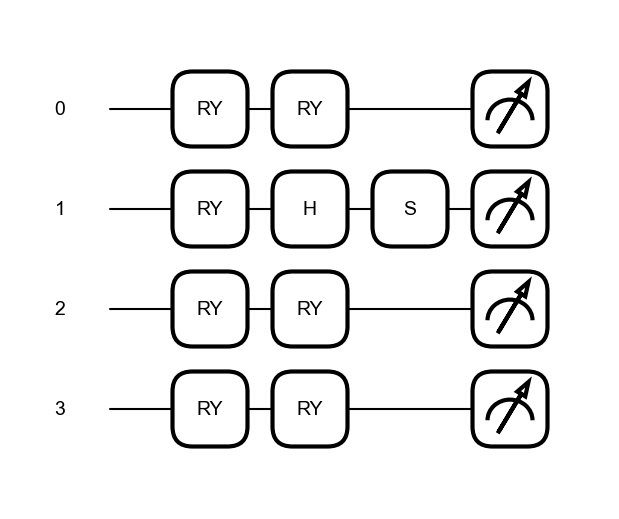

In [38]:
qlayer = qml.qnn.KerasLayer(circuit, {"weights": (4,)}, output_dim=4)
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5])
fig.show()

In [39]:
def extract_windows(image):
    height, width, num_channels = image.shape  # Get image dimensions

    # Reshape to extract all 2x2 windows
    windows = tf.reshape(image, (height // 2, width // 2, 2, 2, num_channels))
    windows = tf.transpose(windows, (0, 2, 1, 3, 4)) 

    # Batching reshape
    windows = tf.reshape(windows, ((height // 2) * (width // 2), 4, num_channels))

    return windows

def extract_all_patches(images):
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    
    return patches

In [40]:
import time

class HQNNQuanv(tf.keras.Model):
    def __init__(self):
        super(HQNNQuanv, self).__init__()
        self.batchnorm = tf.keras.layers.BatchNormalization(axis=1)
        self.quanv = qml.qnn.KerasLayer(circuit, {"weights": (3,)}, output_dim=4)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(10, activation="softmax")
        
    def call(self, inputs):
        num_samples, height, width, num_channels = inputs.shape
        patches = extract_all_patches(inputs)
        
        batch_patches = patches
        batch_patches = tf.reshape(batch_patches, [-1,4])
        
        #start_time = time.process_time()
        quanvoluted_patches = tf.stack([self.quanv(patch) for patch in batch_patches])#circuit(batch_patches, self.quanv.get_weights()[0])
        #print(quanvoluted_patches)
        #print("Time to process patches: ", time.process_time() - start_time)
                    
        quanvoluted_patches = tf.reshape(quanvoluted_patches, [num_samples, 14, 14, 4])
        
        out = quanvoluted_patches
        out = self.batchnorm(out)
        out = self.flatten(out)
        out = self.dense(out)
        return out

In [41]:
train_images_patches = extract_all_patches(train_images)

print(f"Train images shape is {train_images.shape}")
print(f"Train image patches shape is {train_images_patches.shape}")
print(f"Train label image shape is {train_labels.shape}")

test_images_patches = extract_all_patches(test_images)
print(f"Test images shape is {test_images.shape}")
print(f"Test image patches shape is {test_images_patches.shape}")
print(f"Test label image shape is {test_labels.shape}")

Train images shape is (500, 28, 28, 1)
Train image patches shape is (500, 14, 14, 4)
Train label image shape is (500,)
Test images shape is (50, 28, 28, 1)
Test image patches shape is (50, 14, 14, 4)
Test label image shape is (50,)


In [42]:
model = HQNNQuanv()
print(f"model_output_shape: {model(test_images).shape}")
model.summary()

model_output_shape: (50, 10)
Model: "hqnn_quanv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  multiple                  56        
 Normalization)                                                  
                                                                 
 keras_layer_1 (KerasLayer)  multiple                  3         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  7850      
                                                                 
Total params: 7909 (61.79 KB)
Trainable params: 7881 (61.57 KB)
Non-trainable params: 28 (224.00 Byte)
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 3e-4

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-3)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

r = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), batch_size = 5, callbacks=[lr_callback]) 

Epoch 1/10
8/8 [==============================] - 780s 97s/step - loss: 1.8187 - accuracy: 0.3980 - val_loss: 1.2558 - val_accuracy: 0.5400 - lr: 0.0030
Epoch 2/10
8/8 [==============================] - 721s 91s/step - loss: 0.8711 - accuracy: 0.6780 - val_loss: 0.8162 - val_accuracy: 0.6800 - lr: 0.0030
Epoch 3/10
8/8 [==============================] - 1134s 149s/step - loss: 0.6201 - accuracy: 0.7720 - val_loss: 0.6182 - val_accuracy: 0.8200 - lr: 0.0030
Epoch 4/10
1/8 [==>...........................] - ETA: 18:58 - loss: 0.5420 - accuracy: 0.7812

In [ ]:
def CNN():
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4) 
    model = keras.models.Sequential([
        keras.layers.Conv2D(1, (2, 2), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(axis=1),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model2 = CNN()
hist2 = model2.fit(train_images, train_labels, validation_data = (test_images, test_labels), batch_size = 5, epochs=100, verbose=2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(r.history["val_accuracy"], "-ob", label="Quantum Convolutional Neural Network")
ax1.plot(hist2.history["val_accuracy"], "-og", label="Classical Convolutional Neural Network")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(r.history["val_loss"], "-ob", label="Quantum Convolutional Neural Network")
ax2.plot(hist2.history["val_loss"], "-og", label="Classical Convolutional Neural Network")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get predictions on the test set
test_predictions = model.predict(test_images)

# Assuming sparse labels, get class labels from predictions
y_pred = np.argmax(test_predictions, axis=1)
y_true = test_labels
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Example: 'macro' average
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred) 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Assuming you have precision, recall, f1 stored across epochs (e.g., in lists)
epochs = 10  # Adjust if your epochs start from 0 

plt.figure(figsize=(8, 6))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1-Score')
plt.title('Precision, Recall, F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 'fmt='d' displays integers
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()